## EVA_DMBEM: Mini greenhouse for a basilic pot

Giulia Elena Delamotte

MSE Energy & Environment   
SUPSI


November 2022

**Contents**
 1. Physical model
 2. Hypothesis
 3. Thermal model
 4. Mathematical model
 5. Steady state results
 6. Dynamic simulation results
 7. Discussion of the results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

from dm4bem import read_epw, sol_rad_tilt_surf

# Physical model


The goal of this simulation is to determine whether putting my basil plant in a mini greenhouse is enough for it to survive through winter: are the roots going to freeze? Can the greenhouse protect the plant from reaching negative temperatures? That is what we will see.

Here is an illustration of the plant itself.

>
![BasilPlant](BasilPlant1.jpg)

>Figure 1: Photo of my plant

The model is shown in the figure below

>          
![Physical Model](PhysicalModelGH.png)

>Figure 2: model of greenhouse and of the plant in its pot


To simplify, we admit that the greenhouse is a cube with the dimensions $50*50*50 cm$ 
The pot is modelled by a cylinder with radius 15cm and height 30cm. The roots of the plant are modelled as s cylinder with diameter 5 mm.

In [2]:
l = 0.5            # m length of the cube
Sg = 0.5 * 0.5       # m² surface of each glass wall
Sc = 5 * Sg        # m² surface of the whole cubic greenhouse (5 faces)
n_nodes = 8
n_branches = 12

In [3]:
wall = {'Conductivity': 1.4,  # W/(m·K)
        'Density': 2500,        # kg/m³
        'Specific heat': 750,  # J/(kg·K)
        'Width': 0.001,
        'Surface': 0.25},  # m²
wall = pd.DataFrame(wall, index=['Glass'])
wall

,Conductivity,Density,Specific heat,Width,Surface
Glass,1.4,2500,750,0.001,0.25


In [4]:
pot = {'Height' : 0.3,  # 30 cm
       'r2' : 0.15,  # 15 cm
       'r1' : 0.005,  # 5 mm
       'Conductivity' : 1,  # W/(m K)
       'Specific heat' : 1480,  # J/(kg·K)
       'Density' : 1400},  # kg/m³
pot = pd.DataFrame(pot, index=['soil'])
pot

,Height,r2,r1,Conductivity,Specific heat,Density
soil,0.3,0.15,0.005,1,1480,1400


Unfortunately we cannot put together in the same dictionary soil and wall beacuse the elements are not the same, as the soil is actually a cylindrical pot. We will have then different elements for its geometry

# Thermal Model : conductances and capacities
With the thermophysical parameters, we can calculate the capacities (glass and soil) and the conductances. 

>
![Thermal model](ThermalModelGH1.jpg)

>Fig 3. Thermal model of the basil in the greenhouse. 

To go from the physical model to the thermal some hypothesis have been made. 
Looking at the model, the outdoor conductance is made by two conductances in series: one convection $G_{cv}$ (air) and one conduction $G_{cd}$ (glass). The same happens with the inside conductance, made by two conductances in series: conduction (glass) and convection (air). 
Then we have the indoor convection and the soil conductance. The special geometry of the pot (cylinder) makes it a little bit different to calculate the conductance, that is then linked to the diameter of the pot and the diameter of the roots of the plant in the center of the pot.

Why can we put conductances together? If conductances are connected to temperature nodes which have no capacity and/or flow rate source, then the conductances can be considered in series or parallel (depending on the connection).

We must now calculate, for each capacity and conductance, their value. This can be done using the thermophysical parameters and their relative formulas.

## Conduction 
The conduction conductances for the walls, in W/K, are given by:
$$G_{cd(wall)} = \frac{\lambda}{w}S$$
where:

- $\lambda$ - thermal conductvity $[W/(m K)]$ ;
- $w$ - width of the material, $[m]$;
- $S$ - surface area of the wall, $[m^2]$.

Conduction conductances for the pot, in W/K, is of the form:
$$G_{soil} = \frac{2 \lambda \pi h}{ln(r_2 / r_1)}$$
where:

- $r_2$ - external diameter (or diameter of the pot) $[m]$ ;
- $r_1$ - the diameter of the basilic roots $[m]$ ;
- $h$ - height of the pot $[m]$


In [5]:
# conduction of glass
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

#conductance in a cylindrical geometry
G_soil = 2 * pot['Conductivity'] * np.pi * pot['Height']/ (np.log(pot['r2']/pot['r1']))

## Convection
The convection conductances,  in W/K, are given by:
 Convection conductances,
$$G_{cv} = {h S}$$
where:
- $h$ - convection coefficient $[W/(m^2K)]$;
- $S$ - surface area of the wall, $[m^2]$

In [6]:
# convection in air
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)
G_cv = h * wall['Surface'][0]     # glass

The **equivalent conductance**, made by the two conductances (convection + conduction) in series, is given by

$$ G_{g} = \frac{1}{1/G_{cv } + 1/(2 G_{cd})} =  
\frac{1}{\frac{1}{h_{out} S_g} + \frac{w / 2}{\lambda S_g}}
$$

As the indoor and outdoor convection have different values, we will have $G_{go}$ For the outside conductance of glass, and $G_{gi}$ for the indoor one

In [7]:
# Equivalent conductance
Ggo = float(1 / (1 / G_cv['out'] + 1 / (2 * G_cd['Glass'])))
Ggi = float(1 / (1 / G_cv['in'] + 1 / (2 * G_cd['Glass'])))

## Capacities

The thermal capacities, in J/kg, are of the form:

$$C = m c = \rho V c$$

where:
- $m = \rho V$ - mass of the glass wall, $kg$;
- $c$ - specific heat capacity, $J/(kg K)$;
- $\rho$ - density, $kg/m^3$;
- $V$ - Volume, $m^3$;

Here we have two different capacities, the 5 walls and the pot

In [8]:
C_soil = pot['Specific heat']*pot['Density']*np.pi*pot['r2']**2*pot['Height']

In [9]:
C_glass = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']      

# Mathematical model

To build the mathematical model we need to setup the matrices $A$, $G$ and $C$ (incidence, conductances, capacities) and the input vectors $b$ and $f$. They are defined as following:

$A$ : Incidence matrix, represents the oriented graph connecting nodes and branches (12x8)

$G$ : Conductance matrix, represents the conductances at each branch (12x12)

$C$ : Capacity matric, represents the capacity at each node (8x8)

$b$ : Sources (temperatures) (8)

$f$ : Sources (flows) (12)
    
Based on the thermal model, the matrices will look like this:

$$A = \begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
 -1 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\ 
  0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
  0 & -1 & 0 & 0 & 0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
  0 & -1 & 0 & 0 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
  0 & 0 & 0 & -1 & 0 & 1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
  0 & 0 & 0 & 0 & -1 & 1 & 0 & 0 \\
  0 & 0 & 0 & 0 & 0 & -1 & 1 & 0 \\
  0 & 0 & 0 & 0 & 0 & 0 & -1 & 1 \\
\end{bmatrix}$$

G - Conductance Matrix - Diagonal matrix with dimensions n°branches x n° branches (here 12x12). We need a concuctance in order to have a flow (boltzmann flow = potential * conductance

$$G = diag \begin{bmatrix}
Ggo\\ 
 Ggi\\
 Ggo\\ 
 Ggi\\
 Ggo\\ 
 Ggi\\
 Ggo\\ 
 Ggi\\
 Ggo\\ 
 Ggi\\
 G_{cv_{air}}\\ 
 G_{pot}\\
\end{bmatrix}$$

C - Capacity Matrix - Diagonal matrix with capacities on each node. Some capacities can be zero
$$C = diag \begin{bmatrix}
C_g  \\ 
 C_g \\
 C_g  \\
 C_g  \\
 C_g  \\
 0 \\
 0 \\
 C_{pot} \\
\end{bmatrix}$$


Sources : $b$ and $f$


For the temperature sources, the elements correspond of the source of each branch.

$$b = [\begin{matrix}
T_o &0  &T_o  &0  &T_o  &0  &T_o  &0  &T_o &0 &0 &0 &0  
\end{matrix}]^T$$

And fot the flow sources, the elements in f correspond to each node

$$f = [\begin{matrix}
\Phi_N &\Phi_W  &\Phi_S  &\Phi_E  &\Phi_{Roof}  &0  &\Phi_{pot}  &0  
\end{matrix}]^T$$



## Incidence matrix 

Implemented in pyhthon, the incidence matrix gives:

In [10]:
#Incidence matrix
A = np.zeros([12,8])
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 5] = -1, 1    # branch 1: node 0 -> node 5
A[2, 1] = 1
A[3, 1], A[3, 5] = -1, 1
A[4, 2] = 1
A[5, 2], A[5, 5] = -1, 1
A[6, 3] = 1
A[7, 3], A[7, 5] = -1, 1
A[8, 4] = 1
A[9, 4], A[9, 5] = -1, 1
A[10, 5], A[10, 6] = -1,1
A[11, 6], A[11, 7] = -1,1
pd.DataFrame(A)

,0,1,2,3,4,5,6,7
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,-1.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0


## Conductance Matrix



The conductances matrix $G$, is now also implemented in python

In [11]:
G = np.diag([Ggo,Ggi,Ggo,Ggi,Ggo,Ggi,Ggo,Ggi,Ggo,Ggi,int(G_cv['in']),G_soil[0]]) #12x12 matrix
pd.DataFrame(G)

,0,1,2,3,4,5,6,7,8,9,10,11
0,6.19469,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
1,0.00000,1.994302,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
2,0.00000,0.000000,6.19469,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
3,0.00000,0.000000,0.00000,1.994302,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
4,0.00000,0.000000,0.00000,0.000000,6.19469,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
5,0.00000,0.000000,0.00000,0.000000,0.00000,1.994302,0.00000,0.000000,0.00000,0.000000,0.0,0.000000
6,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,6.19469,0.000000,0.00000,0.000000,0.0,0.000000
7,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1.994302,0.00000,0.000000,0.0,0.000000
8,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,6.19469,0.000000,0.0,0.000000
9,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,1.994302,0.0,0.000000


## Capacity matrix

And finally the capcity matrix, following the same procedure, is implemented in python too.


In [12]:
C = np.diag([int(C_glass), int(C_glass), int(C_glass), int(C_glass), int(C_glass), 0, 0, int(C_soil)])
pd.DataFrame(C)

,0,1,2,3,4,5,6,7
0,468,0,0,0,0,0,0,0
1,0,468,0,0,0,0,0,0
2,0,0,468,0,0,0,0,0
3,0,0,0,468,0,0,0,0
4,0,0,0,0,468,0,0,0
5,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,43938


## Sources
There are two types of sources: temperature and flow. In this case, we have the temperature source that is the outdoor temperature To. The flow sources are the absorbed radiation and the transmitted radiation from each one of the five surfaces (N,E,S,W,Roof).
The two types of sources, in the vectors b and f (resp. temperatures and flows)

Here we set the vectors b and f with ones when the value of the source is not zero.

To obtain the total radiation, we need some data from an .epw file. To do so, I downloaded a weather file My hometown from https://www.climate.onebuilding.org/ and kept only what interests us for the simulation: the temperature and the sun radiation. 

In [13]:
filename = './weather_data/CHE_VD_Nyon.Changins.067050_TMYx.2004-2018.epw'
start_date = '2000-01-01'
end_date = '2000-01-15'

In [14]:
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

In [15]:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]
pd.DataFrame(weather)

,temp_air,dir_n_rad,dif_h_rad
2000-01-01 00:00:00+01:00,-0.1,0,0
2000-01-01 01:00:00+01:00,-0.2,0,0
2000-01-01 02:00:00+01:00,-2.2,0,0
2000-01-01 03:00:00+01:00,-2.8,0,0
2000-01-01 04:00:00+01:00,-4.5,0,0
...,...,...,...
2000-01-14 19:00:00+01:00,7.5,0,0
2000-01-14 20:00:00+01:00,6.8,0,0
2000-01-14 21:00:00+01:00,4.4,0,0
2000-01-14 22:00:00+01:00,5.4,0,0


To have a visual understanding of the diffuse and direct radiation, it is useful to plot both. The direct radiation comes from the sun, as we face it directly, and the diffuse one is the radiation that comes from the surroundings that reflect the sun.

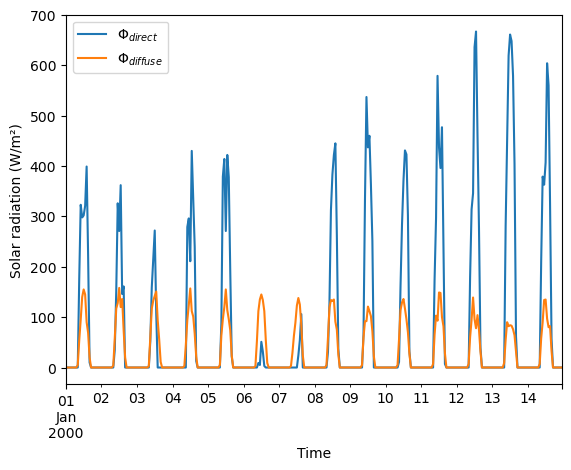

In [16]:
weather[['dir_n_rad', 'dif_h_rad']].plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m²)")
plt.legend(['$Φ_{direct}$', '$Φ_{diffuse}$'])
plt.show()

### Solar radiation for each surface

As each one of the surface has a different orientation (North, South, East, West and the Roof), the total radiation flow is going to be different for each one of them. By using the data from the epw file, we can calculate the total radiation on each surface by using the function sol_rad_tilt_surface, and specifying the orientation of each surface.

In [17]:
S_N = {'slope': 90,'azimuth': 180,'latitude': 45}   #North
S_E = {'slope': 90,'azimuth': -90,'latitude': 45}   #West
S_W = {'slope': 90,'azimuth': 90,'latitude': 45}    #East
S_S = {'slope': 90,'azimuth': 0,'latitude': 45}     #South
S_Roof = {'slope': 0,'azimuth': 0,'latitude': 45}   #Roof

The albedo, the proportion of the radiation that is reflected has to be defined too. 

In [18]:
albedo = 0.2
albedo

0.2

In [19]:
rad_N = sol_rad_tilt_surf(weather, S_N, albedo)
rad_W = sol_rad_tilt_surf(weather, S_W, albedo)
rad_S = sol_rad_tilt_surf(weather, S_S, albedo)
rad_E = sol_rad_tilt_surf(weather, S_E, albedo)
rad_Roof = sol_rad_tilt_surf(weather, S_Roof, albedo)

For example, for the southern face, we have the profile:

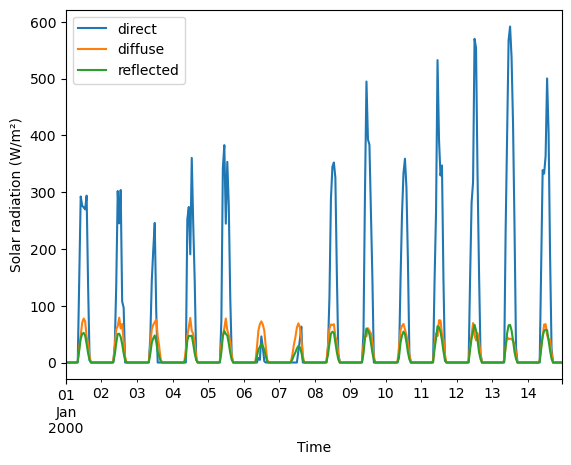

In [20]:
rad_S.plot()
plt.xlabel("Time")
plt.ylabel("Solar radiation (W/m²)")
plt.show()

>Plot : direct, diffuse and reflected radiation of a surface facing south

The total radiation is the sum of direct diffuse and reflected

In [21]:
rad_N['EtotN'] = rad_N.sum(axis=1)
rad_S['EtotS'] = rad_S.sum(axis=1)
rad_E['EtotE'] = rad_E.sum(axis=1)
rad_W['EtotW'] = rad_W.sum(axis=1)
rad_Roof['EtotR'] = rad_Roof.sum(axis=1)

### Flow and temperature source vectors, b and f

Since the temperature source $T_o$ is a time serie, in vector $b$ the branches which contain the temperature source are designated by $1$ and the branches without any temeprature source by $0$. 

In [22]:
b = np.zeros(12)        # branches
b[[0, 2, 4, 6, 8]] = 1   # branches with temperature sources
print(f'b = ', b)

b =  [1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]


The same reasoning works with the flow sources vector f

In [23]:
f = np.zeros(8)         # nodes
f[[0, 1, 2, 3, 4, 6]] = 1     # nodes with heat-flow sources
print(f'f = ', f)

f =  [1. 1. 1. 1. 1. 0. 1. 0.]


Finally we also set the output vector, which indicates which node we are interested in. Here we want the indoor temperature.

In [24]:
y = np.zeros(8)         # nodes
y[7] = 1              # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 0. 1.]


## State space representation
The differential-algebraic system of equations (DAE)

$$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$

is transformed instate-space representation:

$$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

By using the function in dm4bem tc2ss. We give the matrices and the vectors as inputs and obtain the corresponding state space model

In [25]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
#print('As = \n', As, '\n')
#print('Bs = \n', Bs, '\n')
#print('Cs = \n', Cs, '\n')
#print('Ds = \n', Ds, '\n')

## Steady-state analysis
To check that our model is not wrong, we set the outdoor temperature source to 10°C and the flows to zero. 
In the steady state we expect all the temperatures to be at the outdoor temperature (10°C)


In [26]:
b[[0, 2, 4 ,6 ,8]] = 10     # outdoor temperature          
f = np.zeros(8)            # flow-rate sources

In [27]:
θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [10. 10. 10. 10. 10. 10. 10. 10.] °C


This seems correct, the temperature is the same on all temperature nodes.

Now we can set up the vector u, with the non-zero elements of b and f. this is not the final u but we use it for the steady state analysis. 
The goal here is to compare the DAE with the state space, and confirm that they give the same result.

In [28]:
bT = np.array([10, 10, 10, 10, 10]) #To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0, 0, 0])         
u = np.hstack([bT, fQ])
print(f'u = {u}')

u = [10 10 10 10 10  0  0  0  0  0  0]


In [29]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [10.] °C


In [30]:
print(f'Max error between DAE and state-space: \
{max(abs(θ[5] - yss)):.2e} °C')

Max error between DAE and state-space: 8.88e-15 °C


We can conclude that our model is not wrong

## Dynamic simulation

### Time step

The condition for numerical stability of Euler explicit integration method is

$$\left |  \lambda_i \Delta t + 1 \right | < 1, \forall \lambda_i, $$

i.e. in the complex plane, $\lambda_i \Delta t$ is inside a circle of radius 1 centered in {-1, 0j}, where:
- $\lambda_i$ are the eigenvalues of matrix $A_s$,
- $\Delta t$ - time step.

For positive real eigenvalues $\left \{ \lambda \in \Re |\lambda >0  \right \}$, which is the case of thermal networks, the above condition becomes:
$$- \lambda_i \Delta t - 1  < 1, \forall \lambda_i, $$

or

$$ 0 < \Delta t < -\frac{2}{\min \lambda_i} = \min -2 / \lambda_i = \min 2 T_i$$

where $T_i$ are the time constants, $T_i = - \frac{1}{\lambda_i} $

The task now is to setup these eigenvalues

In [31]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = min(-2. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [7.45469808e+01 1.07076268e+05 5.71498892e+01 5.71498892e+01
 5.71498892e+01 5.71498892e+01] s 

2 x Time constants: 
 [1.49093962e+02 2.14152536e+05 1.14299778e+02 1.14299778e+02
 1.14299778e+02 1.14299778e+02] s 

Maximum time step: 114.30 s = 1.90 min


In [47]:
dt  = round((dtmax/100/1.3))*100 
print(f'The time step we use for our simulation is: {dt} s')

The time step we use for our simulation is: 100 s


In [33]:
#settling time
t_resp = 4 * max(-1 / λ)
print('Time constants: \n', -1 / λ, 's \n')
print(f'Settling time: {t_resp:.0f} s = {t_resp / 60:.1f} min \
= {t_resp / (3600):.2f} h = {t_resp / (3600 * 24):.2f} days')

Time constants: 
 [7.45469808e+01 1.07076268e+05 5.71498892e+01 5.71498892e+01
 5.71498892e+01 5.71498892e+01] s 

Settling time: 428305 s = 7138.4 min = 118.97 h = 4.96 days


# Step response 
In the step response we analyse the step input

In [34]:
duration = round(t_resp*2)            # seconds, larger than response time
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
pd.DataFrame(t, columns=['time'])

Duration = 856610 s
Number of time steps = 8566


,time
0,0
1,100
2,200
3,300
4,400
...,...
8561,856100
8562,856200
8563,856300
8564,856400


Let's consider a step response in the conditions used in the steady state analysis To=O and flows are zeros

In [35]:
u = np.zeros([11, n])                # u = [To To To Tisp Φo Φi Qa Φa
u[0:5, :] = 10 * np.ones([5, n])    # To = 10 for n time steps
print('u = ')
pd.DataFrame(u)

u = 


,0,1,2,3,4,5,6,7,8,9,...,8556,8557,8558,8559,8560,8561,8562,8563,8564,8565
0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
2,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
4,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

In [37]:
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

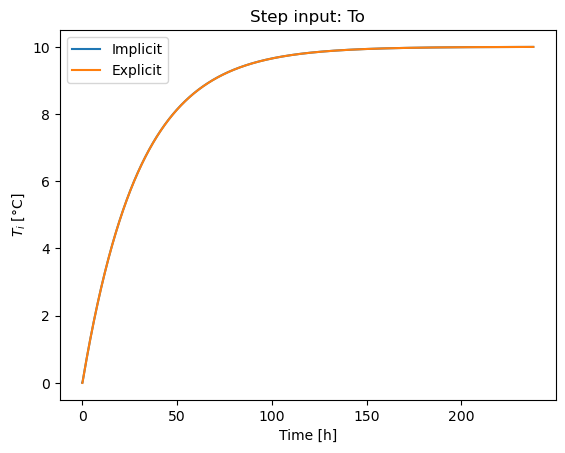

In [38]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To')
ax.legend(['Implicit', 'Explicit'])
plt.show()

,temp_air,EtotN,EtotE,EtotS,EtotW,EtotR
2000-01-01 00:00:00+01:00,-0.1,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:00:00+01:00,-0.2,0.0,0.0,0.0,0.0,0.0
2000-01-01 02:00:00+01:00,-2.2,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:00:00+01:00,-2.8,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:00:00+01:00,-4.5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2000-01-14 19:00:00+01:00,7.5,0.0,0.0,0.0,0.0,0.0
2000-01-14 20:00:00+01:00,6.8,0.0,0.0,0.0,0.0,0.0
2000-01-14 21:00:00+01:00,4.4,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:00:00+01:00,5.4,0.0,0.0,0.0,0.0,0.0


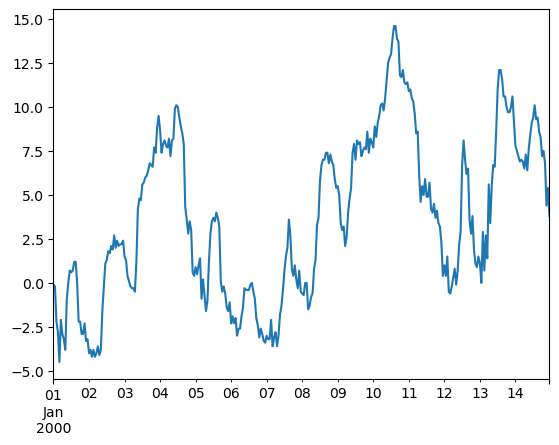

In [39]:
data = pd.concat([weather['temp_air'], rad_N['EtotN'], rad_E['EtotE'], rad_S['EtotS'],rad_W['EtotW'],rad_Roof['EtotR']], axis=1)
weather['temp_air'].plot()


pd.DataFrame(data)

<AxesSubplot:>

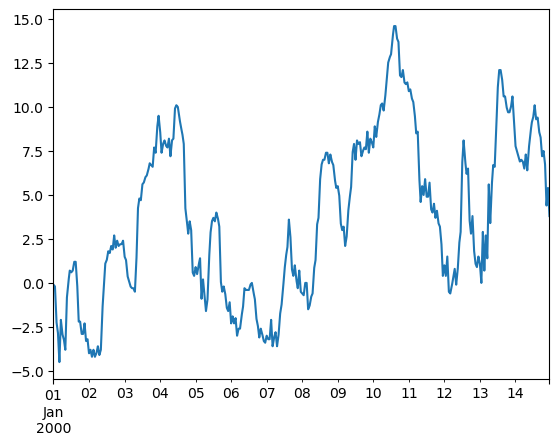

In [40]:
data = data.resample(str(dt) + 'S').interpolate()
data['temp_air'].plot()

The temperature and the total radiation are re-sampled

Now we want to obtain the u vector made out of the temperatures and flow sources

In [41]:
pd.DataFrame(data)

,temp_air,EtotN,EtotE,EtotS,EtotW,EtotR
2000-01-01 00:00:00+01:00,-0.100000,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:01:40+01:00,-0.102778,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:03:20+01:00,-0.105556,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:05:00+01:00,-0.108333,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:06:40+01:00,-0.111111,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2000-01-14 22:53:20+01:00,3.977778,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:55:00+01:00,3.933333,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:56:40+01:00,3.888889,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:58:20+01:00,3.844444,0.0,0.0,0.0,0.0,0.0


To calculate the absorbed and transmitted radiation we must do another step

$\Phi_s = \alpha * Surface * \Phi$

Where the surface is the same for each surface (=Sg)

In [42]:
To = data['temp_air']
#absorptivity of glass

α_g = 0.38    # short wave absortivity: reflective blue glass
τ_g = 0.30    # short wave transmitance: reflective blue glass

Φ_N = data['EtotN']*Sg*α_g
Φ_W = data['EtotW']*Sg*α_g
Φ_E = data['EtotE']*Sg*α_g
Φ_S = data['EtotS']*Sg*α_g
Φ_Roof = data['EtotR']*Sg*α_g
Φ_pot = (data['EtotN']+data['EtotE']+data['EtotS']+data['EtotW']+data['EtotR'])*Sg*τ_g

u = pd.concat([To, To, To, To, To, Φ_N, Φ_W, Φ_S, Φ_E, Φ_Roof, Φ_pot], axis=1)
u.columns.values[[0,1,2,3,4]] = ['To','To','To','To','To']
u.columns.values[[5,6,7,8,9,10]] = ['$\Phi_N$','$\Phi_W$','$\Phi_S$','$\Phi_E$','$\Phi_R$','$\Phi_pot$']

pd.DataFrame(u)

,To,To,To,To,To,$\Phi_N$,$\Phi_W$,$\Phi_S$,$\Phi_E$,$\Phi_R$,$\Phi_pot$
2000-01-01 00:00:00+01:00,-0.100000,-0.100000,-0.100000,-0.100000,-0.100000,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:01:40+01:00,-0.102778,-0.102778,-0.102778,-0.102778,-0.102778,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:03:20+01:00,-0.105556,-0.105556,-0.105556,-0.105556,-0.105556,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:05:00+01:00,-0.108333,-0.108333,-0.108333,-0.108333,-0.108333,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 00:06:40+01:00,-0.111111,-0.111111,-0.111111,-0.111111,-0.111111,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2000-01-14 22:53:20+01:00,3.977778,3.977778,3.977778,3.977778,3.977778,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:55:00+01:00,3.933333,3.933333,3.933333,3.933333,3.933333,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:56:40+01:00,3.888889,3.888889,3.888889,3.888889,3.888889,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-14 22:58:20+01:00,3.844444,3.844444,3.844444,3.844444,3.844444,0.0,0.0,0.0,0.0,0.0,0.0


# Initial conditions

In [43]:
θ_exp = 10 * np.ones([As.shape[0], u.shape[0]])

In [44]:
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

In [45]:
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T


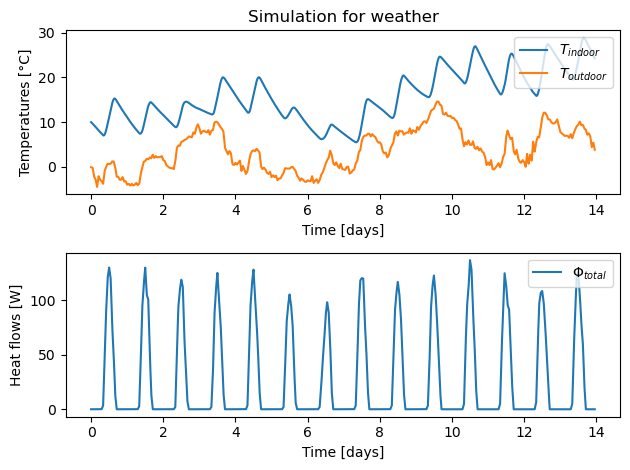

In [46]:
t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600 / 24, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600 / 24, data['temp_air'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [days]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['EtotN'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [days]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

# Conclusion:
Altough the model seems to be quite representative of the reality (the temperature profile is realistic) there are still some considerations that should be made. We can see in the plot above that the temperature can reach quite pleasant values during the day. But the accumulation capacity of the pot is not large enough to fight against the cold winter days and nights. The sun radiation has a great impact, and a few days without sunlight can be enough to condamn the basil. 
One could imagine that the plant might still survive in the model, but one thing has not been considered: the night readiation. In fact, the radiation at night also has an impact, have you ever tried to touch a glass window (in the outside) in the early morning in winter ? It feels really cold. 

So what could be done ? One thing could be take the plant inside at night, where there is heating. If it is not possible to take it inside then maybe covering it with some layers could prevent the freezing. Some other physical parameters could play a role: 
- Increase the capacity of the pot
- Increse the glass' width
- Put the plant on a heated floor, or on a floor with a high capacity that can accumulate heat during the day

Finally last but not least, a great solution would be to cut down the basil and make pesto out of it.

The last option has been chosen and the pesto was delicious, as shown in figures below.

>
![Pesto](Pesto1.jpg)
![Pesto](Pesto2.jpg)


>Figures 4 and 5: Happy ending (for me, not for the plant)